Integrantes:
- Fisher, Agustin
- Ruiz, Lucia Ines

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

In [2]:
train_df = pd.read_csv("data/alturas-pesos-mils-train.csv")
test_df = pd.read_csv("data/alturas-pesos-mils-test.csv")

In [3]:
train_df

,Unnamed: 0,Genero,Peso,Altura
0,7620,Mujer,61.235,162.402
1,1837,Hombre,97.432,181.908
2,3311,Hombre,73.324,172.459
3,9478,Mujer,55.193,157.748
4,7805,Mujer,56.886,151.798
...,...,...,...,...
7995,6395,Mujer,62.215,160.083
7996,2714,Hombre,83.840,177.866
7997,3476,Hombre,75.461,170.910
7998,7084,Mujer,65.461,166.137


Separamos en datos de train y datos de test. `x` es para las features e `y` es para las classes.

In [4]:
features = ['Peso', 'Altura']
target = 'Genero'

x_train = train_df[features].values
y_train = train_df[target].values

x_test = test_df[features].values
y_test = test_df[target].values

Armamos una tupla con las clases, nro de clases y nro de features.

In [5]:
classes = np.unique(y_train)
num_classes = len(classes)
n_features = x_train.shape[1]

print(classes)

['Hombre' 'Mujer']


Computamos las probabilidades a priori y medias

In [6]:
priors = {}
means = {}
for c in classes:
    X_c = x_train[y_train == c]
    priors[c] = X_c.shape[0] / x_train.shape[0]
    means[c] = np.mean(X_c, axis=0)

In [7]:
priors

{'Hombre': 0.50025, 'Mujer': 0.49975}

In [8]:
means

{'Hombre': array([ 84.45539805, 174.91533033]),
 'Mujer': array([ 61.13789495, 161.30471261])}

In [9]:
np.mean(x_train, axis=0)

array([ 72.80247587, 168.11342412])

Calculamos la covarianza

In [10]:
x_train_male = train_df.loc[train_df['Genero']=='Hombre'][['Peso', 'Altura']].values
x_train_female = train_df.loc[train_df['Genero']=='Mujer'][['Peso', 'Altura']].values

cov = np.cov(np.vstack([x_train_male - means['Hombre'], x_train_female - means['Mujer']]).T)

In [11]:
print(f"Covariance: {cov}")

Covariance: [[77.93836353 53.52473405]
 [53.52473405 50.2915853 ]]


In [12]:
def get_gauss_prob(data, means, priors, cov):
    data_np = data
    p_class = {}
    
    L_male = multivariate_normal.pdf(data_np, means['Hombre'], cov)
    L_female = multivariate_normal.pdf(data_np, means['Mujer'], cov)
    p_total = L_male * priors['Hombre'] + L_female * priors['Mujer']
    p_class['Hombre'] = L_male * priors['Hombre'] / p_total
    p_class['Mujer'] = L_female * priors['Mujer'] / p_total

    return p_class


In [13]:
def get_acc_gauss(p_class, data):
    return (((p_class['Hombre'] > p_class['Mujer']) == (data['Genero'] == 'Hombre')).sum() / len(p_class['Hombre']))

Calculamos accuracy de training y test

In [14]:
p_class = get_gauss_prob(x_train, means, priors, cov)
acc_train = get_acc_gauss(p_class, train_df)
print(f"Train Accuracy: {acc_train*100} %")

Train Accuracy: 91.675 %


In [15]:
p_class = get_gauss_prob(x_test, means, priors, cov)
acc_test = get_acc_gauss(p_class, test_df)
print(f"Test Accuracy: {acc_test*100} %")

Test Accuracy: 92.25 %


Graficamos en 3D

In [16]:
N = 300
X = np.linspace(train_df.min()['Peso'], train_df.max()['Peso'], N)
Y = np.linspace(train_df.min()['Altura'], train_df.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z_H_LDA = multivariate_normal.pdf(pos, means['Hombre'], cov)
Z_M_LDA = multivariate_normal.pdf(pos, means['Mujer'], cov)
Z_LDA = get_gauss_prob(x_train, means, priors, cov)['Hombre'], get_gauss_prob(x_train, means, priors, cov)['Mujer']

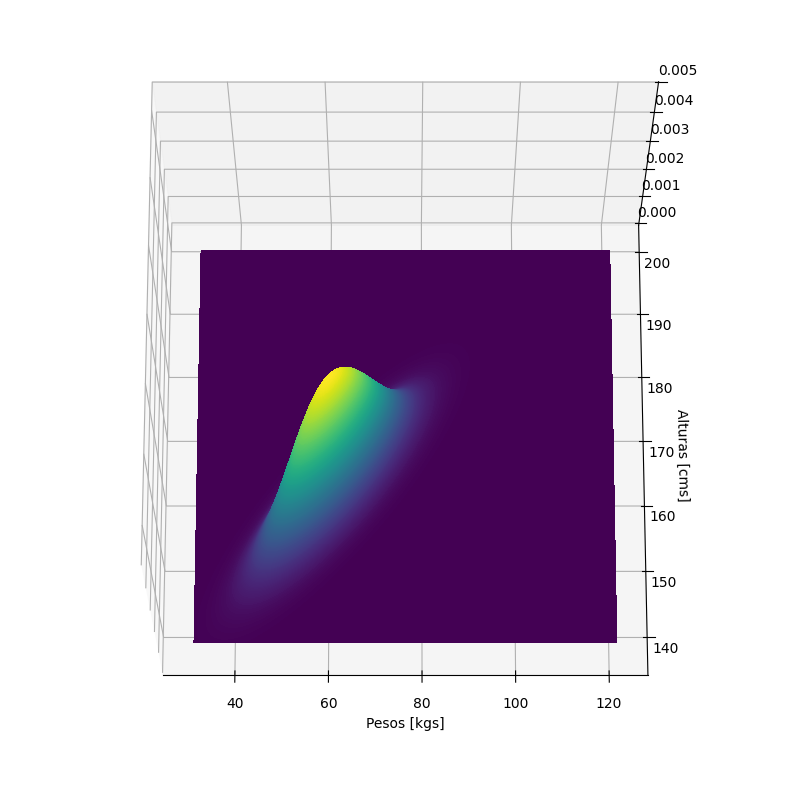

In [17]:
# %matplotlib qt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')
cm = plt.cm.RdBu
#cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
#plt.colorbar(cf, ax=ax)
ax.contourf(X, Y, Z_H_LDA, 256)
ax.contourf(X, Y, Z_M_LDA, 256)
ax.view_init(70, -90)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()

Aca en verdad hay otra campana pero no se renderiza bien. Corriendo con el backend de qt se puede apreciar.

Ahora, la implementacion con SKLearn

In [18]:
# sigo teniendo las mismas features y x_train, etc...

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

def sk_lda_full(x_train, y_train, x_test, y_test):
    lda = LinearDiscriminantAnalysis(priors=None)
    lda.fit(x_train, y_train)
    y_pred = lda.predict(x_test)
    acc_sk = accuracy_score(y_test, y_pred)
    return lda, acc_sk



In [19]:
lda_normal, acc_normal = sk_lda_full(x_train, y_train, x_test, y_test)

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
print(f"Means: {lda_normal.means_}")
print(f"Priors: {lda_normal.priors_}")


Means: [[ 84.45539805 174.91533033]
 [ 61.13789495 161.30471261]]
Priors: [0.50025 0.49975]


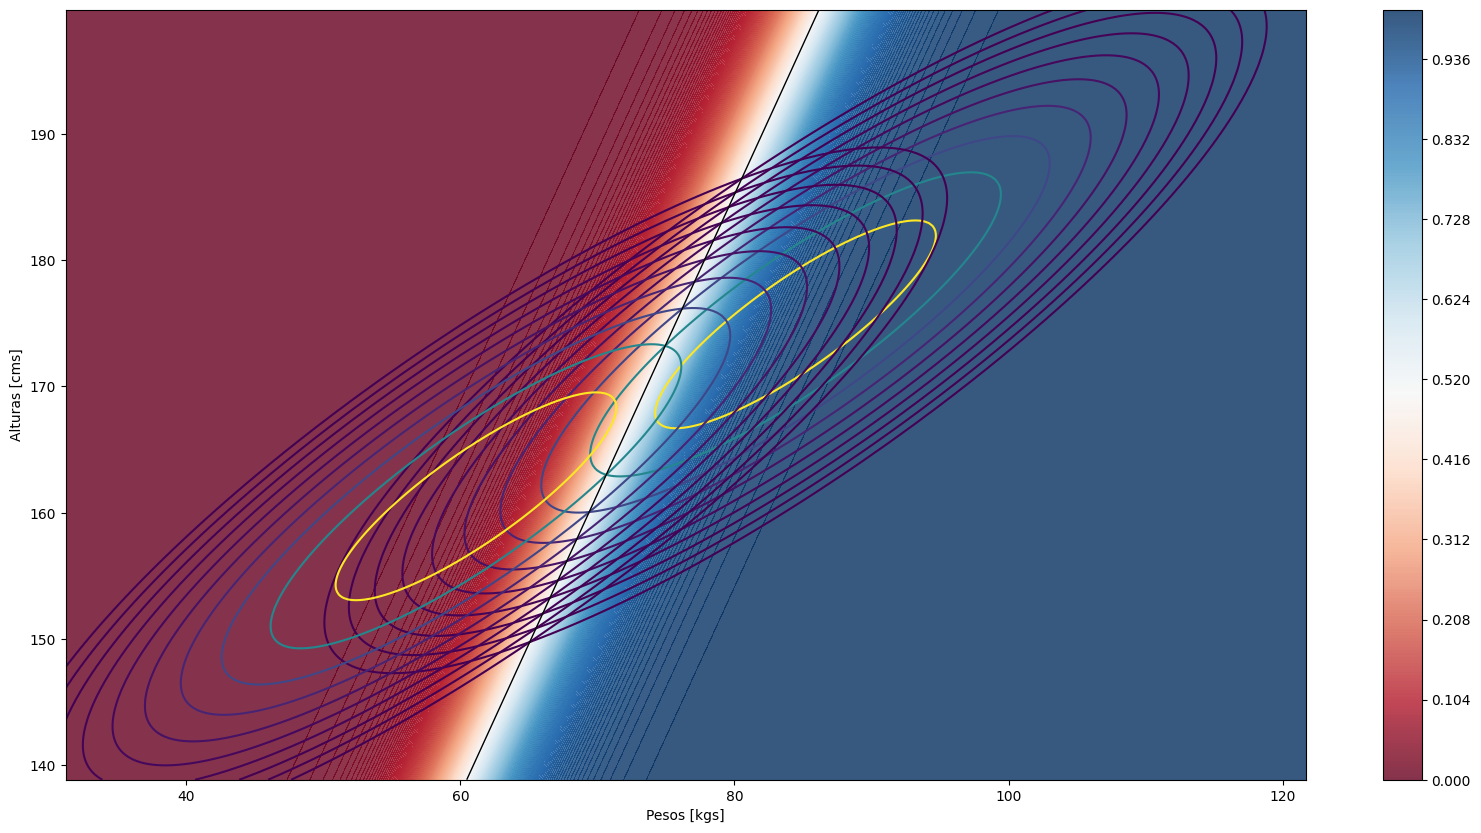

In [21]:
N = 300
X = np.linspace(train_df.min()['Peso'], train_df.max()['Peso'], N)
Y = np.linspace(train_df.min()['Altura'], train_df.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z_H_nb = multivariate_normal.pdf(pos, means['Hombre'], cov)
Z_M_nb = multivariate_normal.pdf(pos, means['Mujer'], cov)
Z_nb = get_gauss_prob(pos, means, priors, cov)['Hombre']

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_nb, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,10)/4
ax.contour(X, Y, Z_H_nb, z_levels)
ax.contour(X, Y, Z_M_nb, z_levels)
ax.contour(X, Y, Z_nb, (0.5,), colors='k', linewidths=1)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()

In [22]:
x_train_p = x_train[:, 0].reshape(-1,1)
x_test_p = x_test[:, 0].reshape(-1,1)
x_train_a = x_train[:, 1].reshape(-1,1)
x_test_a = x_test[:, 1].reshape(-1,1)

Reentrenamos el modelo con p, $p^2$, a, $a^2$, $p*a$. Extensión cuadrática.

In [23]:
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

poly = PolynomialFeatures(degree=2, include_bias=False)  # degree=2 genera p, p^2, a, a^2, p*a
X_train_extended = poly.fit_transform(x_train)
x_test_extended = poly.transform(x_test)

lda_ext, acc_ext = sk_lda_full(X_train_extended, y_train, poly.transform(x_test), y_test)

lda = LinearDiscriminantAnalysis(priors=None)
lda.fit(X_train_extended, y_train)

acc_train = lda.score(X_train_extended, y_train)
acc_test = lda.score(x_test_extended, y_test)

print(f"weights: {lda_ext.coef_}")
print(f"intercept: {lda_ext.intercept_}")
print(f"means: {lda_ext.means_}")
print(f"train accuracy: {acc_train}")
print(f"validation accuracy: {acc_test}")

weights: [[-1.1484025   1.29335473 -0.00134754  0.00549391 -0.00451112]]
intercept: [-66.43702474]
means: [[   84.45539805   174.91533033  7213.38873504 14828.81278766
  30648.38190941]
 [   61.13789495   161.30471261  3813.02221877  9912.59496949
  26066.76905825]]
train accuracy: 0.91575
validation accuracy: 0.92


/tmp/ipykernel_2193/4004702783.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_train[:, 0], x_train[:, 1], c=point_colors, cmap='viridis', edgecolor='k', s=30)


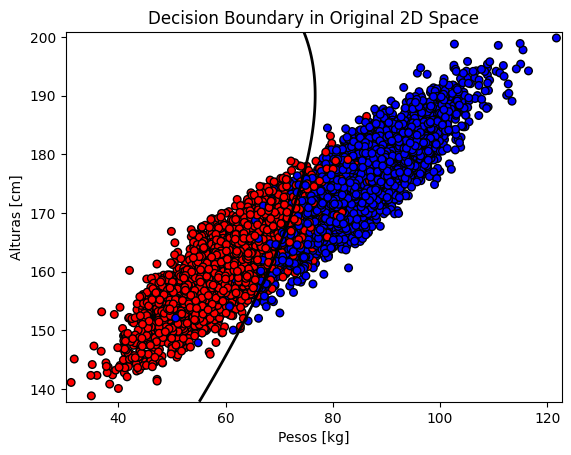

In [24]:
x_min = x_train[:, 0].min() - 1
x_max = x_train[:, 0].max() + 1
y_min = x_train[:, 1].min() - 1
y_max = x_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_extended = poly.transform(grid)

Z = lda.decision_function(grid_extended)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

color_map = {'Hombre': 'blue', 'Mujer': 'red'}
point_colors = [color_map[label] for label in y_train]

plt.scatter(x_train[:, 0], x_train[:, 1], c=point_colors, cmap='viridis', edgecolor='k', s=30)
plt.xlabel("Pesos [kg]")
plt.ylabel("Alturas [cm]")
plt.title("Decision Boundary in Original 2D Space")
plt.show()

**Observaciones:** 
- ahora el modelo tienen 5 parametros de entrada que se ven reflejados en que los weights ahora son un arreglo de 5 elementos.
- el accuracy se mantuvo alrededor del 92%
- al tener ahora 5 parametros se sigue teniendo un umbral de decision que es lineal, pero en 5D. En el espacio 2D original, deja de ser lineal.

LogisticRegression

In [25]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1e12)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
acc_lr = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_lr*100} %")

# Parámetros del modelo
print(f"Coeficientes: {lr.coef_}")
print(f"Intercept: {lr.intercept_}")

Accuracy: 92.2 %
Coeficientes: [[-0.42868627  0.18551927]]
Intercept: [0.00347471]


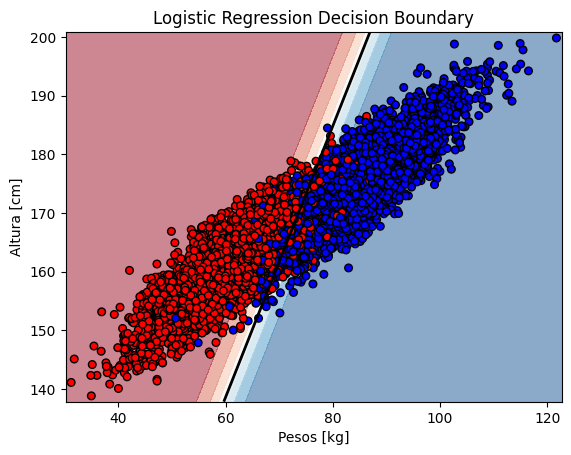

In [26]:
x_min = x_train[:, 0].min() - 1
x_max = x_train[:, 0].max() + 1
y_min = x_train[:, 1].min() - 1
y_max = x_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

grid = np.c_[xx.ravel(), yy.ravel()]

probs = lr.predict_proba(grid)
male_probs = probs[:, 1].reshape(xx.shape)

levels = np.linspace(0, 1, 100)
plt.contourf(xx, yy, male_probs, alpha=0.5, cmap=plt.cm.RdBu_r)

plt.contour(xx, yy, male_probs, levels=[0.5], colors='black', linewidths=2)

color_map = {'Mujer': 'red', 'Hombre': 'blue'}
point_colors = [color_map[label] for label in y_train]

plt.scatter(x_train[:, 0], x_train[:, 1], c=point_colors, edgecolors='k', s=30)

plt.xlabel("Pesos [kg]")
plt.ylabel("Altura [cm]")
plt.title("Logistic Regression Decision Boundary")
plt.show()